# Imports

In [1]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from multiprocessing import Pool, Lock

# Load data

In [2]:
data_dir = 'ml-1m'

movies_filename = 'movies.dat'
users_filename = 'users.dat'
ratings_filename = 'ratings.dat'

movie_columns = ['MovieID', 'Title', 'Genres']
user_columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
rating_columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']


def make_dataframe(data_dir, filename, columns):
    """
    Creates a dataframe from a data file
    
    data_dir: string, directory of data files
    filename: string, data filename
    columns: list, names for the columns of the dataframe
    
    """
    data_file = os.path.join(data_dir, filename)
    return pd.read_csv(data_file, delimiter='::', names=columns, encoding='latin-1', engine='python')


# Make the data frames for each data file
movies = make_dataframe(data_dir, movies_filename, movie_columns)
users = make_dataframe(data_dir, users_filename, user_columns)
ratings = make_dataframe(data_dir, ratings_filename, rating_columns)
data = (users, movies, ratings)

# Utility functions

In [3]:
def rmse(errors):
    """
    Calculates the root mean squared error for an array of errors
    
    errors: array, array containing errors
    """
    return np.sqrt(np.mean(np.square(errors)))


def mae(errors):
    """
    Calculates the mean absolute error for an array of errors
    
    errors: array, array containing errors
    """
    return np.mean(np.abs(errors))


def crop_ratings(arr):
    """
    Ratings can only have values between 1.0 and 5.0. 
    This function sets all ratings > 5 to 5 and < 1 to 1.
    
    arr: array, array containing ratings
    """
    new_arr = np.where(arr > 5.0, 5.0, arr)
    new_arr = np.where(new_arr < 1.0, 1.0, new_arr)
    return new_arr


def rating_errors(data_set, model):
    """
    Calculates the rmse and mae of the errors between ratings from and data set
    and ratings predicted by a model.
    
    test_set: Dataframe, dataframe with the test data
    model: function, function that can act on the rows of a dataframe
    """
    errors = data_set['Rating'] - data_set.apply(model, axis=1)
    return rmse(errors), mae(errors)


def ids_to_indices(movie_ids):
    """
    We want for each movie ID the corresponding index of an array. For the users this 
    is straightforward, since the the user ID's are integers from 1 to the number of 
    users and we can just subtract 1 to get all the indices. For some reason, some integers 
    are skipped in the movie ID's, so we cannot use them directly as indices of an array. 
    
    For example: there is no movie with ID '91', so we want the movie with ID '92' 
    to correspond to an index of 90 (note that the first movie ID is '1' which 
    corresponds to index 0)
    
    Therefore we make an indices array with holes, which has parts like 
    [0, 1, ..., 218, 0, 219, 220, 221, ...]. The IDs '91' and '221' are missing. So a movie 
    with ID '222' will then take the 221st element of this array, which will take the value
    219 for the index, because 2 zeros are inserted for the missing IDs.
    
    movie_ids: array, array containing the ID's of all movies
    """
    ids_to_indices_arr = np.array([], dtype=np.int32)
    skipped_integers = 0
    for i in np.arange(len(movie_ids)):
        if movie_ids[i] == i + 1 + skipped_integers:
            ids_to_indices_arr = np.append(ids_to_indices_arr, i)
        else:
            while movie_ids[i] != i + 1 + skipped_integers:
                ids_to_indices_arr = np.append(ids_to_indices_arr, 0)
                skipped_integers += 1
            ids_to_indices_arr = np.append(ids_to_indices_arr, i)
    return ids_to_indices_arr


def make_movie_indices(data_set, movie_ids):
    """
    For a certain data set with movie ID's, return the corresponding indices of an array.
    
    data_set: Dataframe, dataframe containing ratings
    movie_ids: array, array containing the ID's of all movies
    """
    data_set_movie_ids = data_set['MovieID'].values - 1
    ids_to_indices_arr = ids_to_indices(movie_ids)
    movie_indices = ids_to_indices_arr[data_set_movie_ids]
    return movie_indices

# Naive models 1, 2 and 3

## Functions

In [4]:
def build_naive_model(mean_rating, train_set, model_type, model_specific_params):
    """
    Builds the naive model of a given type.
    
    mean_ratings: float, the mean of all ratings (in the train set)
    train_set: Dataframe, dataframe containing the training data
    model_type: string, type of the model (use '1', '2' or '3')
    model_specific_parmas: dict, dictionary containing objects specific to the model type
    """
    if model_type == '1':
        def model(row):
            return mean_rating
        return model
    elif model_type == '2':
        mean_rating_per_user = np.array([])
        
        # Calculate the mean rating for every user in the training set
        for user_id in model_specific_params['user_ids']:
            user_subset = train_set[train_set['UserID'].values == user_id]
            mean_rating_per_user = np.append(mean_rating_per_user, np.mean(user_subset['Rating']))
        
        # Replace the user mean rating by the global mean rating if it is not available
        mean_rating_per_user = np.where(np.isnan(mean_rating_per_user), mean_rating, mean_rating_per_user)

        def model(row):
            user_id = row['UserID'] - 1
            return mean_rating_per_user[user_id]
        return model
    elif model_type == '3':
        mean_rating_per_movie = np.array([])
        
        # Calculate the mean rating for every movie in the training set
        for movie_id in model_specific_params['movie_ids']:
            movie_subset = train_set[train_set['MovieID'].values == movie_id]
            mean_rating_per_movie = np.append(mean_rating_per_movie, np.mean(movie_subset['Rating']))
        
        # Replace the movie mean rating by the global mean rating if it is not available
        mean_rating_per_movie = np.where(np.isnan(mean_rating_per_movie), mean_rating, mean_rating_per_movie)

        def model(row):
            movie_id = row['MovieID'] - 1
            return mean_rating_per_movie[model_specific_params['ids_to_indices_arr'][movie_id]]
        return model
    else:
        return ValueError(f'Model type {model_type} is unknown.')

    
def naive_model_fold_error(ratings, train_indices, test_indices, model_type, model_specific_params):
    """
    For a given fold, build the naive model and calculate its error on the test set.
    
    ratings: Dataframe, dataframe containing all ratings
    train_indices: array, indices of the training set
    test_indices array, indices of the test set
    model_type: string, type of the model (use '1', '2' or '3')
    model_specific_parmas: dict, dictionary containing objects specific to the model type
    """
    train_set = ratings.iloc[train_indices]
    test_set = ratings.iloc[test_indices]

    mean_rating = train_set['Rating'].mean()

    model = build_naive_model(mean_rating, train_set, model_type, model_specific_params)
    
    train_rmse, train_mae = rating_errors(train_set, model)
    test_rmse, test_mae = rating_errors(test_set, model)
    
    return train_rmse, test_rmse, train_mae, test_mae


def test_naive_model(data, model_type, n_folds=5):
    """
    Calculates the error for a given model. Bias in training and test set selection is reduced
    by using cross-validation. To speed up the process, we use multiprocessing to divide the 
    folds over different cores.
    
    data: tuple, contains the user, movie and rating dataframe
    model_type: string, type of the model (use '1', '2' or '3')
    n_folds: int, the number of folds to use for cross-validation
    """
    users, movies, ratings = data
    
    cv = KFold(n_splits=n_folds, random_state=42, shuffle=True)
    
    print(f'Testing naive model {model_type}...')
    
    if model_type == '1':
        model_specific_params = {}
    elif model_type == '2':
        model_specific_params = {'user_ids': users['UserID']}
    elif model_type == '3':
        model_specific_params = {'movie_ids': movies['MovieID']}
        model_specific_params.update({'ids_to_indices_arr': 
                                      ids_to_indices(model_specific_params['movie_ids'])})
    else:
        return ValueError(f'Model type {model_type} is unknown.')
    
    # Simulatneously calculate the errors for each fold
    params = [(ratings,
               train_indices, 
               test_indices, 
               model_type,
               model_specific_params) for train_indices, test_indices in cv.split(ratings)]
    pool = Pool(n_folds)
    fold_errors = pool.starmap(naive_model_fold_error, params)
    pool.close()
    pool.join()
    
    # fold_errors has dimensions [n_folds, n_error_types]
    print('\nResults:')
    print('mean train rmse', np.mean(fold_errors, axis=0)[0])
    print('mean test rmse', np.mean(fold_errors, axis=0)[1])
    print('mean train mae', np.mean(fold_errors, axis=0)[2])
    print('mean test mae', np.mean(fold_errors, axis=0)[3])

## Testing naive model 1

In [5]:
t0 = time.time()

test_naive_model(data, model_type='1')

run_time = time.time() - t0
print('Run time: ', run_time, ' sec')

Testing naive model 1...

Results:
mean train rmse 1.1171010587983956
mean test rmse 1.1171014505284547
mean train mae 0.9338605988479152
mean test mae 0.9338619186564217
Run time:  3.7883293628692627  sec


## Testing naive model 2

In [6]:
t0 = time.time()

test_naive_model(data, model_type='2')

run_time = time.time() - t0
print('Run time: ', run_time, ' sec')

Testing naive model 2...

Results:
mean train rmse 1.0276727444564144
mean test rmse 1.0354800404316467
mean train mae 0.8227192335238153
mean test mae 0.8289498348484955
Run time:  13.37252926826477  sec


## Testing naive model 3

In [7]:
t0 = time.time()

test_naive_model(data, model_type='3')

run_time = time.time() - t0
print('Run time: ', run_time, ' sec')

Testing naive model 3...

Results:
mean train rmse 0.9742283446389879
mean test rmse 0.9793666761448836
mean train mae 0.7783363352007416
mean test mae 0.7822841972440548
Run time:  10.95653223991394  sec


# Matrix factorization

## Functions

In [8]:
def mf_fold_error(ratings, train_indices, test_indices, users, movies, factors, n_training_steps, lr, lam):
    """
    For a given fold, train the UM matrix and keep track of the rating errors on the train and test set.
    
    ratings: Dataframe, dataframe containing the ratings
    train_indices: array, indices of the training set
    test_indices array, indices of the test set
    users: Dataframe, dataframe containing the users
    movies: Dataframe, dataframe containing the movies
    factors: int, the number of factors to use for the U and M matrix
    n_training_steps: int, the number of steps for training
    lr: float, learning rate 
    lam: float, lambda (used for regularization)
    """
    n_users = len(users)
    n_movies = len(movies)
    
    U = np.random.normal(0.0, 1.0, ((n_users, factors)))
    M = np.random.normal(0.0, 1.0, ((factors, n_movies)))
    
    train_set = ratings.iloc[train_indices]
    test_set = ratings.iloc[test_indices]
    
    # Define an index for every user ID
    train_user_indices = train_set['UserID'].values - 1
    test_user_indices = test_set['UserID'].values - 1
    
    # Define an index for every movie ID
    movie_ids = movies['MovieID'].values
    train_movie_indices = make_movie_indices(train_set, movie_ids)
    test_movie_indices = make_movie_indices(test_set, movie_ids)
    
    # Create a matrix for looking up train set ratings
    train_set_rating_matrix = np.zeros((n_users, n_movies))
    for u, m, rating in zip(train_user_indices, train_movie_indices, train_set['Rating']):
        train_set_rating_matrix[u, m] = rating
    
    errors = np.empty((0, 4))

    for step in range(n_training_steps):
        # Calculate the errors of the ratings predicted by the dot product of U and M
        predicted_ratings = np.dot(U, M)

        train_set_predicted_ratings = predicted_ratings[train_user_indices, train_movie_indices]
        test_set_predicted_ratings = predicted_ratings[test_user_indices, test_movie_indices]

        train_errors = train_set['Rating'] - crop_ratings(train_set_predicted_ratings)
        test_errors = test_set['Rating'] - crop_ratings(test_set_predicted_ratings)
        
        train_rmse, test_rmse = rmse(train_errors), rmse(test_errors)
        
        errors = np.append(errors, np.array([[train_rmse, 
                                              test_rmse, 
                                              mae(train_errors), 
                                              mae(test_errors)]]), axis=0)

        mp_lock.acquire()
        print('step ', step, ' rmse train ', train_rmse, ' rmse test ', test_rmse)
        mp_lock.release()
        
        # Update the U and M matrix
        for u, m in zip(train_user_indices, train_movie_indices):
            u_vec, m_vec = U[u, :], M[:, m]
            error = train_set_rating_matrix[u, m] - np.dot(u_vec, m_vec)
            U[u, :] += lr * (2 * error * m_vec - lam * u_vec)
            M[:, m] += lr * (2 * error * U[u, :] - lam * m_vec)
    
    # errors has shape [n_training_steps, n_error_types]
    return errors


def matrix_factorization(data, factors, n_training_steps, lr, lam, n_folds):
    """
    Calculates the error for the matrix factorization model. Bias in training and test set 
    selection is reduced by using cross-validation. To speed up the process, we use multiprocessing 
    to divide the folds over different cores.
    
    data: tuple, contains the user, movie and rating dataframe
    factors: int, the number of factors to use for the U and M matrix
    n_training_steps: int, the number of steps for training
    lr: float, learning rate 
    lam: float, lambda (used for regularization)
    n_folds: int, the number of folds to use for cross-validation
    """
    users, movies, ratings = data

    cv = KFold(n_splits=n_folds, random_state=42, shuffle=True)

    print('Testing matrix factorization model...')
    
    # Simulatneously calculate the errors for each fold
    params = [(ratings,
               train_indices, 
               test_indices, 
               users, 
               movies, 
               factors, 
               n_training_steps, 
               lr, 
               lam) for train_indices, test_indices in cv.split(ratings)]
    pool = Pool(n_folds)
    fold_errors = pool.starmap(mf_fold_error, params)
    pool.close()
    pool.join()
    
    # fold_errors has dimensions [n_folds, n_training_steps, n_error_types]
    return np.transpose(np.array(fold_errors), (0, 2, 1))

## Testing the model

In [9]:
# Use a lock to prevent print statements from being scrambled
mp_lock = Lock()

number_of_folds = 5
number_of_training_steps = 75
number_of_factors = 10
learning_rate = 0.005
regularization = 0.05

np.random.seed(42)

t0 = time.time()

errors = matrix_factorization(data,
                              factors=number_of_factors,
                              n_training_steps=number_of_training_steps,
                              lr=learning_rate,
                              lam=regularization,
                              n_folds=number_of_folds)

mean_train_rmses = np.mean(errors, axis=0)[0]
mean_test_rmses = np.mean(errors, axis=0)[1]
mean_train_maes = np.mean(errors, axis=0)[2]
mean_test_maes = np.mean(errors, axis=0)[3]

print('\nResults:')
print('Final train rmse: ', np.min(mean_train_rmses))
print('Final test rmse: ', np.min(mean_test_rmses))
print('Final train mae: ', np.min(mean_train_maes))
print('Final test mae: ', np.min(mean_test_maes))

run_time = time.time() - t0

print('Run time: ', run_time, ' sec')

Testing matrix factorization model...
step  0  rmse train  2.5019508435204645  rmse test  2.505985745810919
step  0  rmse train  2.502395730645005  rmse test  2.504208276463159
step  0  rmse train  2.5036820837908937  rmse test  2.499059980936231
step  0  rmse train  2.50312504692612  rmse test  2.5012910024548005
step  0  rmse train  2.502637664414911  rmse test  2.50324101250093
step  1  rmse train  1.378383429890161.406812417182056  rmse test  
step  1  rmse train  1.3855486453868322  rmse test  1.4206325506612607
step  1  rmse train  1.374578568091938  rmse test  1.4082948269287678
step  1  rmse train  1.3784721322705848  rmse test  1.4177585161228956
step  1  rmse train  1.3837881339852656  rmse test  1.4131832873445507
step  2  rmse train  0.9847830519497771  rmse test  1.0361493841791471
step  2  rmse train  0.9839282514083296  rmse test  1.033250925357526
step  2  rmse train  0.9809674959677085  rmse test  1.0385716351252674
step  2  rmse train  0.9819292094912271  rmse test  1

step  22  rmse train  0.8350517004109062  rmse test  0.9132855992928145
step  23  rmse train  0.8318617212963242  rmse test  0.9084726902026825
step  23  rmse train  0.8322080088287448  rmse test  0.9156725726872004
step  23  rmse train  0.8319287154898657  rmse test  0.9101692093737196
step  23  rmse train  0.8322224594355224  rmse test  0.9105188335034032
step  23  rmse train  0.8324579497132251  rmse test  0.9117802367204397
step  24  rmse train  0.8293730333823  rmse test  0.9070806090216235
step  24  rmse train  0.8298131671733846  rmse test  0.9142612817658045
step  24  rmse train  0.8297102704859431  rmse test  0.9091313459800147
step  24  rmse train  0.8294275470655599  rmse test  0.9087523724943434
step  24  rmse train  0.8299772849344755  rmse test  0.9103548132675923
step  25  rmse train  0.826996369297587  rmse test  0.9057658923809384
step  25  rmse train  0.8275282399806091  rmse test  0.9129242199335552
step  25  rmse train  0.8273156907267926  rmse test  0.9078191644548

step  45  rmse train  0.7968045595934697  rmse test  0.8927830431284217
step  45  rmse train  0.7964760026516021  rmse test  0.8912065008694243
step  46  rmse train  0.7954744008397058  rmse test  0.8893388743630711
step  46  rmse train  0.7962908379331431  rmse test  0.891776226613867
step  46  rmse train  0.7969198297799978  rmse test  0.8960216582005549
step  46  rmse train  0.795847388077164  rmse test  0.8923309821280001
step  46  rmse train  0.7955227293599264  rmse test  0.8907121649091126
step  47  rmse train  0.7945555066743207  rmse test  0.8888973430361786
step  47  rmse train  0.7954142298384029  rmse test  0.8913517067960152
step  47  rmse train  0.7960080918676763  rmse test  0.8955339235359496
step  47  rmse train  0.7949277444230625  rmse test  0.8918974075045495
step  47  rmse train  0.7946058392971822  rmse test  0.8902331425742291
step  48  rmse train  0.7936715600002023  rmse test  0.8884750971342698
step  48  rmse train  0.7945722112251163  rmse test  0.89094613687

step  68  rmse train  0.7826166042716771  rmse test  0.8881264170482555
step  68  rmse train  0.7817705241878579  rmse test  0.8857868069499427
step  68  rmse train  0.7815145868373561  rmse test  0.8832432291037693
step  69  rmse train  0.7810191900255841  rmse test  0.8825094577184901
step  69  rmse train  0.7825551154566688  rmse test  0.8854028596194108
step  69  rmse train  0.7821812059189506  rmse test  0.8878754813093396
step  69  rmse train  0.7813487231783487  rmse test  0.8855882284144281
step  69  rmse train  0.7811033468602429  rmse test  0.8830185784466127
step  70  rmse train  0.7806201109171953  rmse test  0.8823248012994216
step  70  rmse train  0.7821713780161252  rmse test  0.8852376897277019
step  70  rmse train  0.7817594293720553  rmse test  0.8876305292921574
step  70  rmse train  0.7809397197878086  rmse test  0.8853945155956866
step  70  rmse train  0.7807055556848921  rmse test  0.8828008959368389
step  71  rmse train  0.7802341155520468  rmse test  0.882146306

## Plots

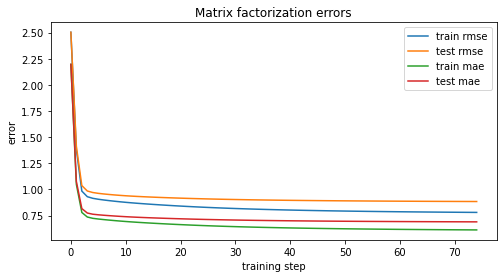

In [10]:
training_steps = np.arange(number_of_training_steps)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(training_steps, mean_train_rmses, label='train rmse', rasterized=True)
ax.plot(training_steps, mean_test_rmses, label='test rmse', rasterized=True)
ax.plot(training_steps, mean_train_maes, label='train mae', rasterized=True)
ax.plot(training_steps, mean_test_maes, label='test mae', rasterized=True)
ax.set_title('Matrix factorization errors')
ax.set_xlabel('training step')
ax.set_ylabel('error')
ax.legend()
plt.savefig('mf_errors.pdf')
plt.show()